# Fraud Model Revised

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from faker import Faker
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,  roc_auc_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [45]:
X.shape

(1000000, 14)

In [46]:
fake = Faker()
np.random.seed(42)
Faker.seed(42)

In [47]:
# number of rows
num_rows = 1_000_000
num_unique_accounts = int(num_rows * 0.2)
num_unique_receivers = int(num_rows * 0.1)

# Unique account and receiver IDs
account_ids = [fake.random_number(digits=10, fix_len=True) for _ in range(num_unique_accounts)]
receiver_ids = [fake.random_number(digits=10, fix_len=True) for _ in range(num_unique_receivers)]

Suggested Columns for Fraud Detection

Transaction ID: Unique identifier for each transaction.

Account ID: Unique identifier for the account performing the transaction.

Account Type: Indicates if it’s a personal or business account.

Account Creation Date: For calculating the account age.

Transaction Amount: The monetary value of each transaction.

Transaction Date and Time: Exact timestamp of each transaction to identify unusual timings and frequency patterns.

Payment Channel: Specifies the method used (e.g., bank transfer, Deposit, Sport Betting, Airtime).

Receiver Account ID: Unique identifier for the destination account.

Transaction Type: Category of the transaction (e.g., Bank Transfer, Airtime, Deposit, Sport Betting, ).

Transaction Status: Status of the transaction (e.g., success, failure, pending).

Daily Transaction Amount: Cumulative transaction amount per user per day, which can be calculated if not readily available.

Total Daily Transactions: Total number of transactions per user per day, useful for rules based on frequency.

In [48]:
# Data Generation
data = {
    "transaction_id": [fake.uuid4() for _ in range(num_rows)],
    "account_id": np.random.choice(account_ids, num_rows),  # Randomly assign one of the unique account IDs to each transaction
    "account_type": np.random.choice(["Personal", "Business"], num_rows, p=[0.7, 0.3]),
    "account_creation_date": [fake.date_between(start_date='-5y', end_date='today') for _ in range(num_rows)],
    "transaction_amount": np.random.choice(
        [1000, 5000, 10000, 25000, 50000, 100000, 500000, 1000000, 5000000, 7000000],
        num_rows, p=[0.3, 0.25, 0.2, 0.1, 0.05, 0.03, 0.02, 0.03, 0.01, 0.01]
    ),
    "transaction_date_time": [fake.date_time_this_year() for _ in range(num_rows)],
    "payment_type": np.random.choice(["Credit", "Debit"], num_rows),
    "receiver_account_id": np.random.choice(receiver_ids, num_rows),
    "transaction_type": np.random.choice(
        ["Bank Transfer", "Airtime", "Deposit", "Sport Betting"], num_rows, p=[0.6, 0.1, 0.2, 0.1]
    ),
}

In [ ]:
# Initialize storage for transaction data
data ={
    "transaction_id": [],
    "account_id": [],
    "account_type": [],
    "account_creation_date": [],
    "transaction_amount": [],
    "transaction_date_time": [],
    "payment_type": [],
    "receiver_account_id": [],
    "transaction_type": []
}
# Track account and receiver pair transaction counts and timestamps
account_receiver_transactions = {account_id: {} for account_id in account_ids}
account_transactions = {account_id: [] for account_id in account_ids}
receiver_transactions = {receiver_id: [] for receiver_id in receiver_ids}

# Generate transactions
for transaction_id in range(num_rows):
    # Randomly select account ID and receiver ID
    account_id = random.choice(account_ids)
    receiver_id = random.choice(receiver_ids)

    # Track and control the number of transactions per account-receiver pair
    if receiver_id not in account_receiver_transactions[account_id]:
        account_receiver_transactions[account_id][receiver_id] = []

    # Apply rule: Limit to 3 transactions to the same receiver within 1 hour
    if len(account_receiver_transactions[account_id][receiver_id]) >= 3:
        continue  # Skip adding more transactions if limit is reached for that account-receiver pair

    # Generate other transaction details
    data['transaction_id'].append(fake.uuid4())
    data['account_id'].append(account_id)
    data['account_type'].append(np.random.choice(["Personal", "Business"]))
    data['account_creation_date'].append(fake.date_between(start_date='-5y', end_date='today'))
    data['transaction_amount'].append(np.random.choice(
        [1000, 5000, 10000, 25000, 50000, 100000, 500000, 1000000, 5000000, 7000000],
        p=[0.3, 0.25, 0.2, 0.1, 0.05, 0.03, 0.02, 0.03, 0.01, 0.01]
    ))
    data['transaction_date_time'].append(fake.date_time_this_year())
    data['payment_type'].append(np.random.choice(["Credit", "Debit"]))
    data['receiver_account_id'].append(receiver_id)
    data['transaction_type'].append(np.random.choice(
        ["Bank Transfer", "Airtime", "Deposit", "Sport Betting"],
        p=[0.6, 0.1, 0.2, 0.1]
    ))

    # Append to account and receiver transactions
    account_transactions[account_id].append(receiver_id)
    receiver_transactions[receiver_id].append(account_id)

In [50]:
# df = pd.DataFrame(data)
# df.to_csv('synthetic_data.csv', index=False)

In [51]:
transaction_data = data
df = pd.DataFrame(transaction_data)
df.to_csv('syn_data.csv', index=False)

In [52]:
df = pd.read_csv('syn_data.csv')
df.head()

,transaction_id,account_id,account_type,account_creation_date,transaction_amount,transaction_date_time,payment_type,receiver_account_id,transaction_type
0,e58a3d35-b950-4c55-b4a2-5542fd7f69a7,5314135070,Personal,2021-05-28,5000,2024-05-02 01:57:42,Debit,5557319056,Bank Transfer
1,ff36b954-4f29-4e15-b81a-3168beec8bea,8031197711,Personal,2024-07-28,100000,2024-11-10 17:45:41,Debit,1761503272,Bank Transfer
2,63e9cd32-5969-4318-b2cf-0a1833cd4a7c,7393181744,Personal,2020-03-28,5000,2024-04-19 02:26:11,Credit,1824977975,Bank Transfer
3,1e1a4d9d-21c9-4f26-a61b-2b966e095091,9803688055,Business,2020-09-04,1000000,2024-07-22 19:26:47,Credit,1295209101,Airtime
4,8bb4d557-4376-4163-bd4f-ad78c4748ac4,2507547298,Business,2020-10-21,10000,2024-04-28 13:51:36,Credit,2892613049,Bank Transfer


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   transaction_id         1000000 non-null  object
 1   account_id             1000000 non-null  int64 
 2   account_type           1000000 non-null  object
 3   account_creation_date  1000000 non-null  object
 4   transaction_amount     1000000 non-null  int64 
 5   transaction_date_time  1000000 non-null  object
 6   payment_type           1000000 non-null  object
 7   receiver_account_id    1000000 non-null  int64 
 8   transaction_type       1000000 non-null  object
dtypes: int64(3), object(6)
memory usage: 68.7+ MB


In [54]:
# converting datetimes
df['account_creation_date'] = pd.to_datetime(df['account_creation_date'])
df['transaction_date_time'] = pd.to_datetime(df['transaction_date_time'])

# amounts to float
df['transaction_amount'] = df['transaction_amount'].astype(float)
# df['daily_transaction_amount'] = df['transaction_amount'].astype(float)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   transaction_id         1000000 non-null  object        
 1   account_id             1000000 non-null  int64         
 2   account_type           1000000 non-null  object        
 3   account_creation_date  1000000 non-null  datetime64[ns]
 4   transaction_amount     1000000 non-null  float64       
 5   transaction_date_time  1000000 non-null  datetime64[ns]
 6   payment_type           1000000 non-null  object        
 7   receiver_account_id    1000000 non-null  int64         
 8   transaction_type       1000000 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 68.7+ MB


In [56]:
df.describe()

,account_id,account_creation_date,transaction_amount,transaction_date_time,receiver_account_id
count,1.000000e+06,1000000,1.000000e+06,1000000,1.000000e+06
mean,5.501144e+09,2022-05-15 14:14:32.438401280,1.711166e+05,2024-06-08 12:55:41.292364544,5.493252e+09
min,1.000015e+09,2019-11-15 00:00:00,1.000000e+03,2024-01-01 00:00:14,1.000072e+09
25%,3.253642e+09,2021-02-13 00:00:00,1.000000e+03,2024-03-20 16:28:40.249999872,3.234954e+09
50%,5.510231e+09,2022-05-15 00:00:00,5.000000e+03,2024-06-08 10:25:38.500000,5.485027e+09
75%,7.746867e+09,2023-08-15 00:00:00,1.000000e+04,2024-08-27 09:55:31.249999872,7.747979e+09
max,9.999992e+09,2024-11-14 00:00:00,7.000000e+06,2024-11-15 05:13:07,9.999966e+09
std,2.596960e+09,NaN,8.628293e+05,NaN,2.603085e+09


## Feature Engineering Based on KENAM rules

In [57]:
# Account age
df["account_age_days"] = (pd.to_datetime("today") - pd.to_datetime(df["account_creation_date"])).dt.days

# Daily transaction amount for each account
df['transaction_date'] = df['transaction_date_time'].dt.date
df["daily_transaction_amount"] = df.groupby(["account_id","transaction_date"])["transaction_amount"].transform("sum")

# Total daily transaction count for each account
df["total_daily_transactions"] = df.groupby(["account_id","transaction_date"])["transaction_id"].transform("count")

# Transaction frequency and time delta to the same account
df["time_delta_same_account"] = df.groupby(['account_id', 'receiver_account_id'])["transaction_date_time"].diff().fillna(pd.Timedelta(seconds=0))
df["transaction_frequency_same_account"] = df.groupby(['account_id', 'receiver_account_id'])["transaction_id"].transform("count")

# Calculate transaction frequency for each transaction
df["transaction_frequency"] = df.groupby("account_id")["transaction_id"].transform("count")

# previos transaction time
df['previous_transaction_time'] = df.groupby('account_id')['transaction_date_time'].shift(1)

# # For VAS-specific transaction frequencies, you would need to define and calculate them
# df["vas_transaction_frequency_sport_betting"] = df[df["transaction_type"] == "Sport Betting"].groupby("account_id")["transaction_id"].transform("count")
# df["vas_transaction_frequency_airtime"] = df[df["transaction_type"] == "Airtime"].groupby("account_id")["transaction_id"].transform("count")

### Creating the function for the target column based on the KENAM rules

In [58]:
def is_suspicious(row):
    # Rule 1: Regulatory Requirements (High value transactions for personal and business accounts)
    if (row['transaction_amount'] >= 5_000_000 and row['account_type'] == 'Personal') or \
       (row['transaction_amount'] >= 10_000_000 and row['account_type'] == 'Business'):
        return 1

    # Rule 2: Frequent Transactions to Same Account over 3 times within 1 hour
    if row['transaction_frequency_same_account'] > 3 and \
       row['time_delta_same_account'] <= pd.Timedelta(hours=1):
        return 1

    # Rule 3: High Total Daily Transaction Amount
    if row['daily_transaction_amount'] > 5_000_000:
        return 1

    # Rule 4: Unusually High Transaction Frequency (exceeds 8 in 1 hour and type is 'Bank Transfer')
    if row['transaction_frequency'] > 8 and row['transaction_type'] == 'Bank Transfer' and \
       row['time_delta_same_account'] <= pd.Timedelta(hours=1):
        return 1

    # Rule 5: Late-Night Bank Transfers (after 1 transaction)
    if row['transaction_date_time'].strftime('%H:%M:%S') >= '23:00:00' and \
       row['transaction_date_time'].strftime('%H:%M:%S') <= '05:00:00' and \
       row['transaction_type'] == 'Bank Transfer':
        if row['previous_transaction_time'] is not None and \
           row['previous_transaction_time'] < row['transaction_date_time']:
            return 1

    # Rule 6: Early-Morning Bank Transfers with Amounts over 49,000
    if row['transaction_date_time'].strftime('%H:%M:%S') >= '00:00:00' and \
       row['transaction_date_time'].strftime('%H:%M:%S') <= '05:00:00' and \
       row['transaction_type'] == 'Bank Transfer' and row['transaction_amount'] > 49_000:
        return 1

    # Rule 7: New Account Restrictions for Bank Transfers
    if row['account_age_days'] <= 14 and row['transaction_frequency'] > 3 and \
       row['transaction_amount'] > 99_000 and row['transaction_type'] == 'Bank Transfer':
        return 1

    # Rule 8: New Account Restrictions for VAS (Sport Betting)
    if row['account_age_days'] <= 14 and row['transaction_type'] == 'Sport Betting' and \
       row['transaction_amount'] > 30_000:
        recent_sport_betting = df[(df['account_id'] == row['account_id']) &
                                  (df['transaction_type'] == 'Sport Betting') &
                                  (df['transaction_date_time'] >= row['transaction_date_time'] - pd.Timedelta(hours=3))]
        if recent_sport_betting['transaction_id'].count() > 3:
            return 1

    # Rule 9: New Account Restrictions for VAS (Airtime)
    if row['account_age_days'] <= 14 and row['transaction_type'] == 'Airtime' and \
       row['transaction_amount'] > 4_999:
        recent_airtime_purchase = df[(df['account_id'] == row['account_id']) &
                                     (df['transaction_type'] == 'Airtime') &
                                     (df['transaction_date_time'] >= row['transaction_date_time'] - pd.Timedelta(hours=1))]
        if recent_airtime_purchase['transaction_id'].count() > 3:
            return 1

    return 0

In [59]:
# creating the target column
df['is_suspicious'] = df.apply(is_suspicious, axis=1)

In [60]:
df.head()

,transaction_id,account_id,account_type,account_creation_date,transaction_amount,transaction_date_time,payment_type,receiver_account_id,transaction_type,account_age_days,transaction_date,daily_transaction_amount,total_daily_transactions,time_delta_same_account,transaction_frequency_same_account,transaction_frequency,previous_transaction_time,is_suspicious
0,e58a3d35-b950-4c55-b4a2-5542fd7f69a7,5314135070,Personal,2021-05-28,5000.0,2024-05-02 01:57:42,Debit,5557319056,Bank Transfer,1267,2024-05-02,5000.0,1,0 days,1,6,NaT,0
1,ff36b954-4f29-4e15-b81a-3168beec8bea,8031197711,Personal,2024-07-28,100000.0,2024-11-10 17:45:41,Debit,1761503272,Bank Transfer,110,2024-11-10,100000.0,1,0 days,1,10,NaT,1
2,63e9cd32-5969-4318-b2cf-0a1833cd4a7c,7393181744,Personal,2020-03-28,5000.0,2024-04-19 02:26:11,Credit,1824977975,Bank Transfer,1693,2024-04-19,5000.0,1,0 days,1,3,NaT,0
3,1e1a4d9d-21c9-4f26-a61b-2b966e095091,9803688055,Business,2020-09-04,1000000.0,2024-07-22 19:26:47,Credit,1295209101,Airtime,1533,2024-07-22,1000000.0,1,0 days,1,3,NaT,0
4,8bb4d557-4376-4163-bd4f-ad78c4748ac4,2507547298,Business,2020-10-21,10000.0,2024-04-28 13:51:36,Credit,2892613049,Bank Transfer,1486,2024-04-28,10000.0,1,0 days,1,5,NaT,0


In [61]:
class_counts = df['is_suspicious'].value_counts()
class_counts

is_suspicious
0    889253
1    110747
Name: count, dtype: int64

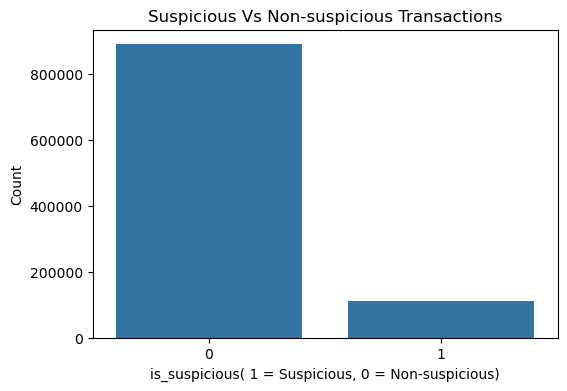

In [62]:
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Suspicious Vs Non-suspicious Transactions')
plt.xlabel('is_suspicious( 1 = Suspicious, 0 = Non-suspicious)')
plt.ylabel('Count')
plt.show()

In [63]:
cat_columns = ['account_type', 'payment_type','transaction_type']

In [64]:
df_encoded = pd.get_dummies(df, columns=cat_columns, drop_first=True)
df_encoded.head()

,transaction_id,account_id,account_creation_date,transaction_amount,transaction_date_time,receiver_account_id,account_age_days,transaction_date,daily_transaction_amount,total_daily_transactions,time_delta_same_account,transaction_frequency_same_account,transaction_frequency,previous_transaction_time,is_suspicious,account_type_Personal,payment_type_Debit,transaction_type_Bank Transfer,transaction_type_Deposit,transaction_type_Sport Betting
0,e58a3d35-b950-4c55-b4a2-5542fd7f69a7,5314135070,2021-05-28,5000.0,2024-05-02 01:57:42,5557319056,1267,2024-05-02,5000.0,1,0 days,1,6,NaT,0,True,True,True,False,False
1,ff36b954-4f29-4e15-b81a-3168beec8bea,8031197711,2024-07-28,100000.0,2024-11-10 17:45:41,1761503272,110,2024-11-10,100000.0,1,0 days,1,10,NaT,1,True,True,True,False,False
2,63e9cd32-5969-4318-b2cf-0a1833cd4a7c,7393181744,2020-03-28,5000.0,2024-04-19 02:26:11,1824977975,1693,2024-04-19,5000.0,1,0 days,1,3,NaT,0,True,False,True,False,False
3,1e1a4d9d-21c9-4f26-a61b-2b966e095091,9803688055,2020-09-04,1000000.0,2024-07-22 19:26:47,1295209101,1533,2024-07-22,1000000.0,1,0 days,1,3,NaT,0,False,False,False,False,False
4,8bb4d557-4376-4163-bd4f-ad78c4748ac4,2507547298,2020-10-21,10000.0,2024-04-28 13:51:36,2892613049,1486,2024-04-28,10000.0,1,0 days,1,5,NaT,0,False,False,True,False,False


In [65]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column                              Non-Null Count    Dtype          
---  ------                              --------------    -----          
 0   transaction_id                      1000000 non-null  object         
 1   account_id                          1000000 non-null  int64          
 2   account_creation_date               1000000 non-null  datetime64[ns] 
 3   transaction_amount                  1000000 non-null  float64        
 4   transaction_date_time               1000000 non-null  datetime64[ns] 
 5   receiver_account_id                 1000000 non-null  int64          
 6   account_age_days                    1000000 non-null  int64          
 7   transaction_date                    1000000 non-null  object         
 8   daily_transaction_amount            1000000 non-null  float64        
 9   total_daily_transactions            1000000 non-null  int6

In [82]:
new_df = df_encoded.drop(['transaction_id', 'time_delta_same_account','transaction_date', 'previous_transaction_time','account_creation_date', 'transaction_date_time'], axis=1)
new_df

,account_id,transaction_amount,receiver_account_id,account_age_days,daily_transaction_amount,total_daily_transactions,transaction_frequency_same_account,transaction_frequency,is_suspicious,account_type_Personal,payment_type_Debit,transaction_type_Bank Transfer,transaction_type_Deposit,transaction_type_Sport Betting
0,5314135070,5000.0,5557319056,1267,5000.0,1,1,6,0,True,True,True,False,False
1,8031197711,100000.0,1761503272,110,100000.0,1,1,10,1,True,True,True,False,False
2,7393181744,5000.0,1824977975,1693,5000.0,1,1,3,0,True,False,True,False,False
3,9803688055,1000000.0,1295209101,1533,1000000.0,1,1,3,0,False,False,False,False,False
4,2507547298,10000.0,2892613049,1486,10000.0,1,1,5,0,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,9932724522,5000.0,2072471875,892,5000.0,1,1,8,0,False,False,False,True,False
999996,8556561792,10000.0,9060197998,12,10000.0,1,1,7,0,False,False,False,False,True
999997,6925939276,1000.0,7537957261,79,1000.0,1,1,3,0,False,False,True,False,False
999998,8505098449,1000.0,9052281859,1102,1000.0,1,1,8,0,False,True,True,False,False


In [66]:
X = df_encoded.drop(columns=['transaction_id', 'time_delta_same_account','transaction_date', 'previous_transaction_time','account_creation_date', 'transaction_date_time', 'is_suspicious'])
y = df_encoded['is_suspicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   account_id                          1000000 non-null  int64  
 1   transaction_amount                  1000000 non-null  float64
 2   receiver_account_id                 1000000 non-null  int64  
 3   account_age_days                    1000000 non-null  int64  
 4   daily_transaction_amount            1000000 non-null  float64
 5   total_daily_transactions            1000000 non-null  int64  
 6   transaction_frequency_same_account  1000000 non-null  int64  
 7   transaction_frequency               1000000 non-null  int64  
 8   account_type_Personal               1000000 non-null  bool   
 9   payment_type_Debit                  1000000 non-null  bool   
 10  transaction_type_Bank Transfer      1000000 non-null  bool   
 11  transaction_

In [68]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [70]:
log_model = LogisticRegression()
log_model.fit(X_train_resampled, y_train_resampled)

log_pred = log_model.predict(X_test_scaled)

print(classification_report(y_test, log_pred))
print(confusion_matrix(y_test, log_pred)
)

              precision    recall  f1-score   support

           0       0.99      0.92      0.95    177869
           1       0.58      0.92      0.71     22131

    accuracy                           0.92    200000
   macro avg       0.78      0.92      0.83    200000
weighted avg       0.94      0.92      0.92    200000

[[162956  14913]
 [  1861  20270]]


In [71]:
log_model = LogisticRegression()
log_model.fit(X_train_resampled, y_train_resampled)

y_pred_log = log_model.predict(X_test_scaled)
logreg_auc = roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:, 1])

print(logreg_auc)
print(classification_report(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))

0.9702970644684489
              precision    recall  f1-score   support

           0       0.99      0.92      0.95    177869
           1       0.58      0.92      0.71     22131

    accuracy                           0.92    200000
   macro avg       0.78      0.92      0.83    200000
weighted avg       0.94      0.92      0.92    200000

[[162956  14913]
 [  1861  20270]]


In [72]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_resampled, y_train_resampled)

xgb_pred = xgb_model.predict(X_test_scaled)

print(classification_report(y_test, xgb_pred))
print(confusion_matrix(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98    177869
           1       0.77      0.94      0.85     22131

    accuracy                           0.96    200000
   macro avg       0.88      0.95      0.91    200000
weighted avg       0.97      0.96      0.96    200000

[[171567   6302]
 [  1254  20877]]


In [73]:
X_train_resampled[0, :]

array([ 4.26298168e-01, -1.92503904e-01, -1.58501808e+00, -1.92684070e-01,
       -1.94099652e-01, -1.25273197e-01, -7.07124460e-03,  1.75280657e-03,
        6.55312288e-01,  1.00148360e+00, -1.22412315e+00,  2.00332639e+00,
       -3.33458319e-01])

In [74]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb_model.predict(X_test_scaled)
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])

print(xgb_auc)
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

0.995904528161415
              precision    recall  f1-score   support

           0       0.99      0.96      0.98    177869
           1       0.77      0.94      0.85     22131

    accuracy                           0.96    200000
   macro avg       0.88      0.95      0.91    200000
weighted avg       0.97      0.96      0.96    200000

[[171567   6302]
 [  1254  20877]]


In [75]:
rec = recall_score(y_test, y_pred_xgb)
print(rec)

0.9433374000271113


In [80]:
x_try = [[1032847592, 5000, 2048571934, 100, 25000, 2, 1, 2, True, True, True, False, True]]
y = xgb_model.predict(x_try)
y

array([1])

In [84]:
x_try2 = [[5314135070, 5000.0, 5557319056, 1267, 5000.0, 1, 1, 6, True, True, True, False, False]]
y = xgb_model.predict(x_try2)
y

array([1])

In [87]:

x_try3 = [[4788614822,	10000.0, 7366793916, 109, 10000.0, 1, 1, 8,	True, False, True, False, False]]
y = xgb_model.predict(x_try3)
y

array([1])

In [ ]:
# Save the best model (based on AUC score)
if logreg_auc > xgb_auc:
    best_model = logreg
    best_model_name = 'logreg_model_1.pkl'
else:
    best_model = xgb_model
    best_model_name = 'xgb_model_1.pkl'

# Save the best model using joblib
import joblib
joblib.dump(best_model, best_model_name)

['xgb_model_1.pkl']

In [85]:
y_test.head()

987231    0
79954     0
567130    0
500891    0
55399     0
Name: is_suspicious, dtype: int64

In [86]:
X_test.head()

,account_id,transaction_amount,receiver_account_id,account_age_days,daily_transaction_amount,total_daily_transactions,transaction_frequency_same_account,transaction_frequency,account_type_Personal,payment_type_Debit,transaction_type_Bank Transfer,transaction_type_Deposit,transaction_type_Sport Betting
987231,4788614822,10000.0,7366793916,109,10000.0,1,1,8,True,False,True,False,False
79954,3551873441,5000.0,1728443093,1603,5000.0,1,1,6,True,True,True,False,False
567130,4808812279,25000.0,8683810872,980,25000.0,1,1,4,True,False,False,False,False
500891,8316523850,1000.0,8155375969,1510,1000.0,1,1,4,False,True,True,False,False
55399,3987330088,10000.0,6272959157,1718,10000.0,1,1,6,True,False,True,False,False
